In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt


In [ ]:
!unzip /content/content2.zip -d /content/content2

Archive:  /content/content2.zip
   creating: /content/content2/content2/
   creating: /content/content2/content2/skeletonized/
   creating: /content/content2/content2/skeletonized/Bharadvajas Twist/
  inflating: /content/content2/content2/skeletonized/Bharadvajas Twist/1. Bharadvajas Twist.png  
  inflating: /content/content2/content2/skeletonized/Bharadvajas Twist/10. Bharadvajas Twist.png  
  inflating: /content/content2/content2/skeletonized/Bharadvajas Twist/11. Bharadvajas Twist.png  
  inflating: /content/content2/content2/skeletonized/Bharadvajas Twist/12. Bharadvajas Twist.png  
  inflating: /content/content2/content2/skeletonized/Bharadvajas Twist/13. Bharadvajas Twist.png  
  inflating: /content/content2/content2/skeletonized/Bharadvajas Twist/14. Bharadvajas Twist.png  
  inflating: /content/content2/content2/skeletonized/Bharadvajas Twist/15. Bharadvajas Twist.png  
  inflating: /content/content2/content2/skeletonized/Bharadvajas Twist/16. Bharadvajas Twist.png  
  inflatin

In [ ]:
# Define the path to your dataset
data_dir = '/content/content2/content2/skeletonized'
#careful

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

In [ ]:
# Define the split sizes
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

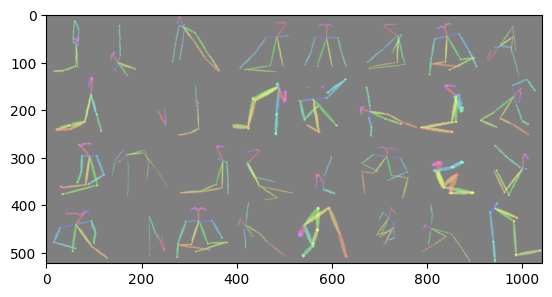

Monkey Pose Sleeping Vishnu Pose Upward Plank Pose Half Lord of the Fishes Pose Easy Pose Lotus Pose Scale Pose Side Crane Pose Cobra Pose Peacock Pose Monkey Pose Cow Pose Cow Face Pose Extended Side Angle Pose Cow Face Pose Revolved Head to Knee Pose Half Lord of the Fishes Pose Wild Thing Staff Pose Hero Pose Plow Pose Shoulder Pressing Pose Heron Pose Full Boat Pose Hero Pose Four-Limbed Staff Pose Scale Pose Formidable Pose Intense Side Stretch Pose Noose Pose Revolved Triangle Pose Cow Pose


In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join(f'{dataset.classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
!nvidia-smi

Wed Aug 14 02:43:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### training with plots


In [ ]:
import torch

def compute_validation_loss(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation for efficiency
        for inputs, labels in val_loader:
            if use_cuda and torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Accumulate loss and the number of samples
            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

    # Calculate average loss over all validation samples
    avg_loss = total_loss / total_samples
    return avg_loss


In [ ]:
import torch
from collections import Counter

# Get all labels from the dataset (train set preferred)
all_labels = []
# Global list to store learning rate histories from different runs
global_lr_histories = []

for _, labels in train_loader:
    all_labels.extend(labels.numpy())

# Count the frequency of each class
class_counts = Counter(all_labels)

# Calculate the weights
total_samples = sum(class_counts.values())
class_weights = {class_idx: total_samples/class_counts[class_idx] for class_idx in class_counts}

# Convert to tensor and align with your class indices
weights = torch.tensor([class_weights[i] for i in range(len(dataset.classes))], dtype=torch.float32)


In [ ]:
def get_accuracy2(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(len(dataset.classes)))
    class_total = list(0. for i in range(len(dataset.classes)))

    with torch.no_grad():
        for imgs, labels in dataloader:
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            outputs = model(imgs)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item() if c.dim() > 0 else c.item()
                class_total[label] += 1
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    overall_accuracy = correct / total
    class_accuracy = [(dataset.classes[i], class_correct[i] / class_total[i]) for i in range(len(dataset.classes)) if class_total[i] > 0]

    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    # print(f"Class Accuracy: {class_accuracy}")

    return overall_accuracy


In [ ]:
def train_plot2(model, num_epochs, learning_rate=0.001, weights = weights, patience=4):
    # Move the weights to GPU if available
    if use_cuda and torch.cuda.is_available():
        weights = weights.cuda()

    # Apply the weights to the loss function
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=0)

    iters, losses, train_acc, valid_acc = [], [], [], []
    val_losses, train_losses = [], []  # To track loss values for plotting
    lr_history = []  # To track learning rate changes
    start_time = time.time()

    best_val_accuracy = 0
    best_train_accuracy = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data

            if use_cuda and torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (i + 1) % len(train_loader) == 0:
                iters.append(epoch * len(train_loader) + i)
                current_val_accuracy = get_accuracy2(model, val_loader)
                current_train_accuracy = get_accuracy2(model, train_loader)
                valid_acc.append(current_val_accuracy)
                train_acc.append(current_train_accuracy)

                val_loss = compute_validation_loss(model, val_loader, criterion)
                train_loss = compute_validation_loss(model, train_loader, criterion)
                val_losses.append(val_loss)
                train_losses.append(train_loss)

                print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.3f}')
                # print(f'Current Learning Rate: {lr_val}')
                print(f"\tTime Elapsed: {time.time() - start_time:.2f} s")

                running_loss = 0.0

                if current_val_accuracy > best_val_accuracy:
                    best_val_accuracy = current_val_accuracy
                    patience_counter = 0  # Reset patience counter
                else:
                    patience_counter += 1

                if current_train_accuracy > best_train_accuracy:
                    best_train_accuracy = current_train_accuracy

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    print("Final Training Accuracy: {}".format(best_train_accuracy))
    print("Final Validation Accuracy: {}".format(best_val_accuracy))

    plt.title("Losses")
    plt.plot(iters, train_losses, label="Train losses")
    plt.plot(iters, val_losses, label="Val losses")
    plt.legend(loc='best')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Accuracy")
    plt.plot(iters, valid_acc, label="Validation")
    plt.plot(iters, train_acc, label="Training")
    plt.legend(loc='best')
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.show()


### Model Testing

### RESIDUAL NETWORK WITH SIMPLE CNN

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()

        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNetSimpleCNN(nn.Module):
    def __init__(self):
        super(ResNetSimpleCNN, self).__init__()
        self.block1 = ResidualBlock(3, 16)
        self.pool = nn.MaxPool2d(2, 2)
        self.block2 = ResidualBlock(16, 32)
        self.fc1 = nn.Linear(32 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, len(dataset.classes))

    def forward(self, x):
        x = self.pool(self.block1(x))
        x = self.pool(self.block2(x))
        x = x.view(-1, 32 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


CUDA is available!  Training on GPU ...
Overall Accuracy: 0.4155
Overall Accuracy: 0.5445
Epoch 1, Loss: 3.046
	Time Elapsed: 27.58 s
Overall Accuracy: 0.5160
Overall Accuracy: 0.6852
Epoch 2, Loss: 1.589
	Time Elapsed: 55.62 s
Overall Accuracy: 0.5205
Overall Accuracy: 0.7414
Epoch 3, Loss: 1.143
	Time Elapsed: 83.03 s
Overall Accuracy: 0.5845
Overall Accuracy: 0.8099
Epoch 4, Loss: 0.874
	Time Elapsed: 110.48 s
Overall Accuracy: 0.6279
Overall Accuracy: 0.8529
Epoch 5, Loss: 0.714
	Time Elapsed: 138.33 s
Overall Accuracy: 0.5822
Overall Accuracy: 0.8749
Epoch 6, Loss: 0.567
	Time Elapsed: 168.95 s
Overall Accuracy: 0.5776
Overall Accuracy: 0.8700
Epoch 7, Loss: 0.437
	Time Elapsed: 196.72 s
Overall Accuracy: 0.6416
Overall Accuracy: 0.8988
Epoch 8, Loss: 0.377
	Time Elapsed: 224.22 s
Overall Accuracy: 0.5868
Overall Accuracy: 0.8939
Epoch 9, Loss: 0.316
	Time Elapsed: 252.57 s
Overall Accuracy: 0.6210
Overall Accuracy: 0.9389
Epoch 10, Loss: 0.321
	Time Elapsed: 280.29 s
Final Traini

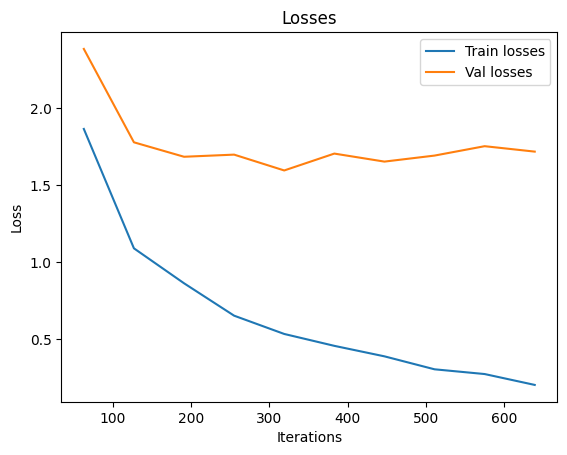

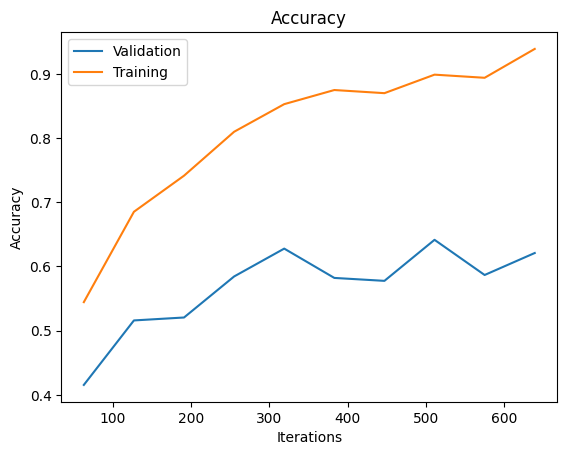

In [ ]:
model_residual_block = ResNetSimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model_residual_block.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot2(model_residual_block, num_epochs=10, learning_rate=0.0002)

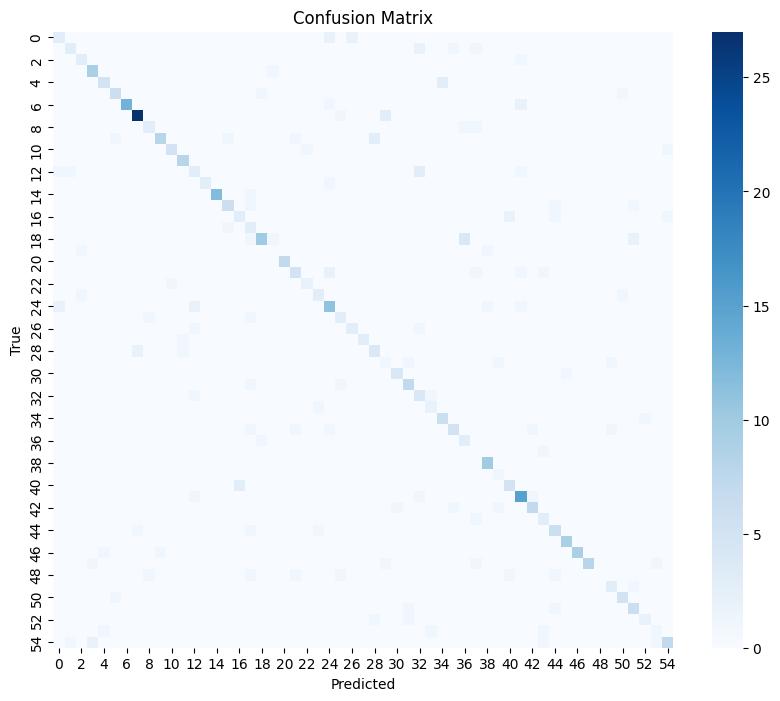

In [ ]:
model_residual_block.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        if use_cuda and torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        outputs = model_residual_block(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#Compute confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds)

#Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
test_acc=get_accuracy2(model_residual_block, test_loader)
print(f'Final Test Accuracy: {100 * test_acc:.2f}%')

Overall Accuracy: 0.6925
Final Test Accuracy: 69.25%


### Recall Precision F1

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [ ]:
model_residual_block.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        if use_cuda and torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        outputs = model_residual_block(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import pandas as pd

class_names = dataset.classes

# Calculate metrics
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# Create a DataFrame and display the top 6 and worst 6 classes
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Recall': recall,
    'Precision': precision,
    'F1': f1
})

metrics_df = metrics_df.sort_values(by='F1', ascending=False)
top_6 = metrics_df.head(6)
worst_6 = metrics_df.tail(6)
final_df = pd.concat([top_6, worst_6])

print(final_df)



                            Class    Recall  Precision        F1
45           Sleeping Vishnu Pose  1.000000   0.900000  0.947368
6                   Cow Face Pose  0.875000   1.000000  0.933333
7                        Cow Pose  0.903226   0.933333  0.918033
11                     Eagle Pose  0.875000   0.875000  0.875000
5                      Cobra Pose  0.875000   0.875000  0.875000
14  Extended Hand to Big Toe Pose  0.769231   1.000000  0.869565
12                      Easy Pose  0.333333   0.300000  0.315789
23                 Half Frog Pose  0.200000   0.500000  0.285714
29      Intense Side Stretch Pose  0.250000   0.333333  0.285714
48            Supine Spinal Twist  0.166667   0.500000  0.250000
37                   Pendant Pose  0.000000   0.000000  0.000000
19                      Frog Pose  0.000000   0.000000  0.000000


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import pandas as pd
import numpy as np

class_names = dataset.classes

# Calculate metrics
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# Create a DataFrame with the results
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Recall': recall,
    'Precision': precision,
    'F1': f1
})

# Randomly choose 12 classes from the dataset
random_classes = metrics_df.sample(n=12, random_state=42)  # Set random_state for reproducibility

random_classes = random_classes.sample(frac=1).reset_index(drop=True)

# Display the randomly selected classes
print(random_classes)


                     Class    Recall  Precision        F1
0          Upward Bow Pose  0.750000   0.375000  0.500000
1          Side Crane Pose  0.500000   0.666667  0.571429
2               Camel Pose  0.900000   0.692308  0.782609
3                Easy Pose  0.333333   0.300000  0.315789
4                Hero Pose  0.600000   1.000000  0.750000
5            Upward salute  0.750000   0.500000  0.600000
6                Frog Pose  0.000000   0.000000  0.000000
7   Lord of the Dance Pose  0.888889   0.571429  0.695652
8               Scale Pose  0.777778   0.666667  0.717949
9               Lotus Pose  0.833333   0.416667  0.555556
10             Embryo Pose  0.750000   0.750000  0.750000
11              Cobra Pose  0.875000   0.875000  0.875000


In [ ]:
import torch
import matplotlib.pyplot as plt
import random

def visualize_test_results(model, test_loader, class_names):
    model.eval()  # Set the model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Loop to display 10 random tests
    for _ in range(10):
        # Randomly select a batch and an image within that batch
        images, labels = next(iter(test_loader))
        idx = random.randint(0, len(images) - 1)

        image = images[idx].unsqueeze(0).to(device)
        true_label = labels[idx].item()

        # Get the model's prediction
        with torch.no_grad():
            output = model(image)
            _, pred_label = torch.max(output, 1)
            pred_label = pred_label.item()

        # Plot the original skeletonized image
        plt.figure(figsize=(10, 2))

        # First column: random skeletonized image
        plt.subplot(1, 4, 1)
        plt.imshow(image.cpu().squeeze().permute(1, 2, 0))
        plt.title(f"True: {class_names[true_label]}")
        plt.axis('off')

        # Second column: true label
        plt.subplot(1, 4, 2)
        plt.text(0.5, 0.5, class_names[true_label], fontsize=12, ha='center', va='center')
        plt.title("True Label")
        plt.axis('off')

        # Third column: model's prediction
        plt.subplot(1, 4, 3)
        plt.text(0.5, 0.5, class_names[pred_label], fontsize=12, ha='center', va='center')
        plt.title("Predicted Label")
        plt.axis('off')

        # Fourth column: skeletonized image that corresponds to the prediction
        pred_image = get_image_by_label(test_loader, pred_label)

        plt.subplot(1, 4, 4)
        plt.imshow(pred_image.squeeze().permute(1, 2, 0))
        plt.title(f"Predicted: {class_names[pred_label]}")
        plt.axis('off')

        plt.show()

def get_image_by_label(loader, label):
    # This function returns an image corresponding to a given label from the dataset.
    # Adjust this function to suit how your dataset is structured.
    for images, labels in loader:
        for img, lbl in zip(images, labels):
            if lbl == label:
                return img
    return None


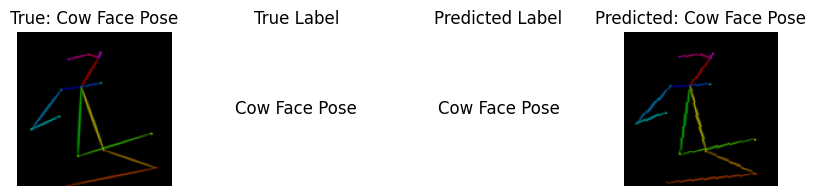

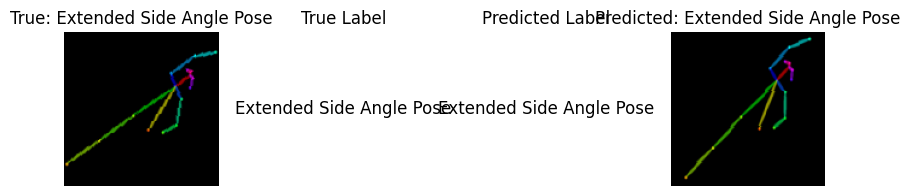

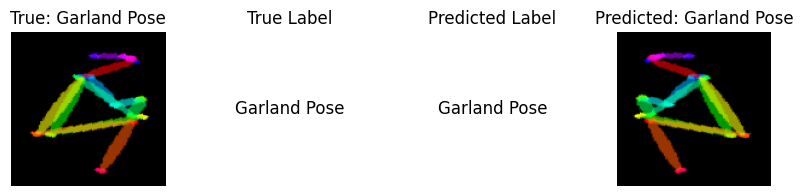

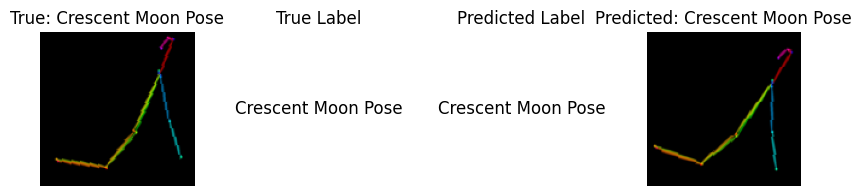

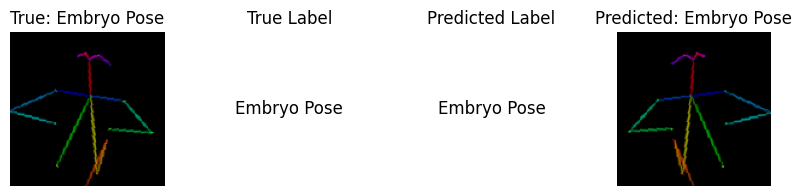

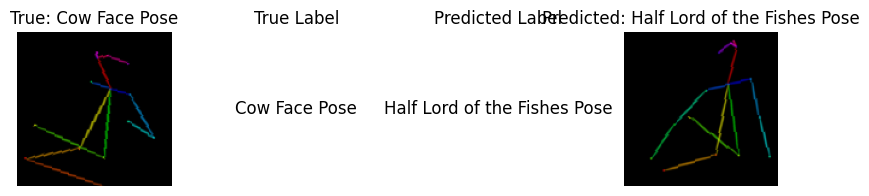

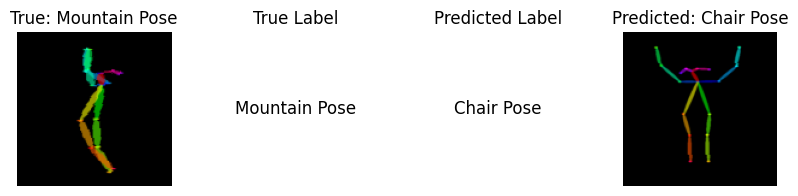

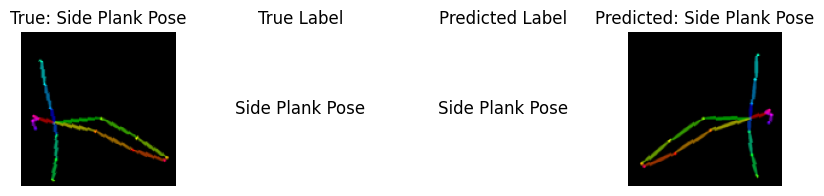

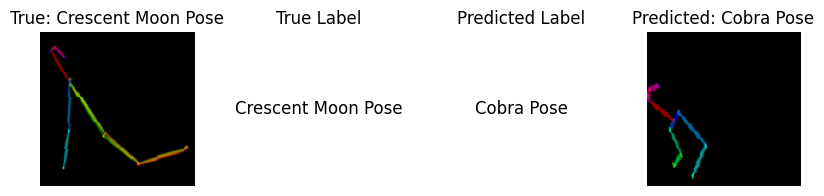

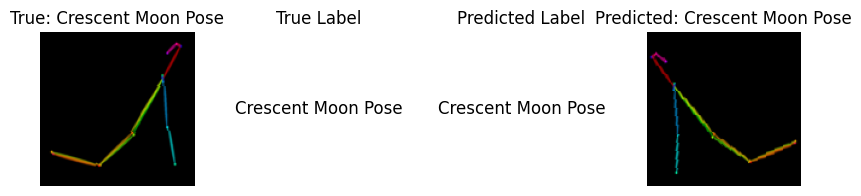

In [ ]:
visualize_test_results(model_residual_block, test_loader, dataset.classes)

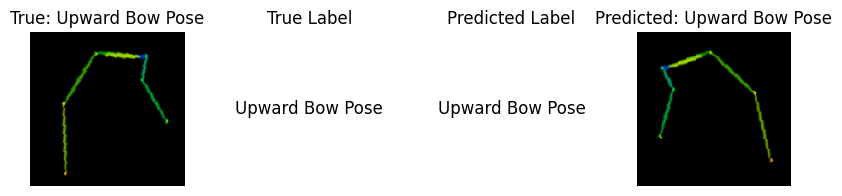

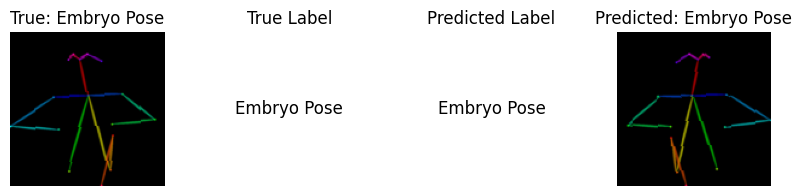

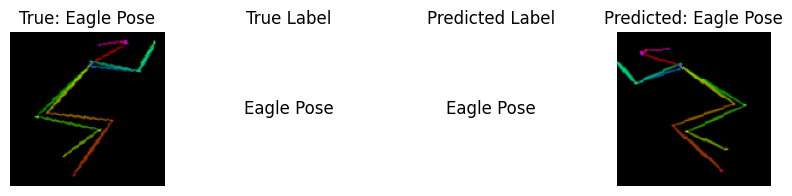

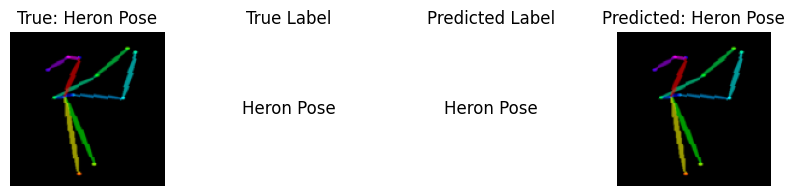

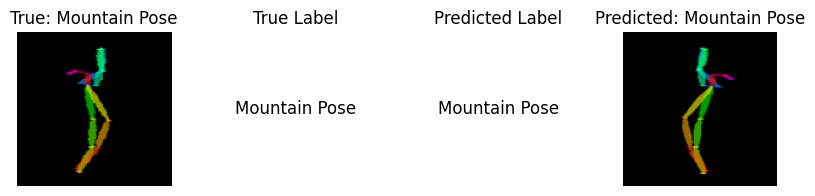

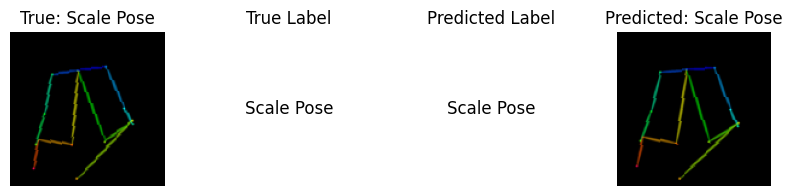

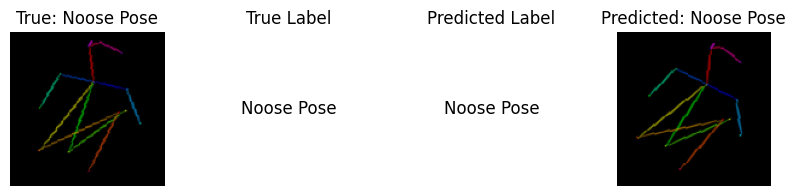

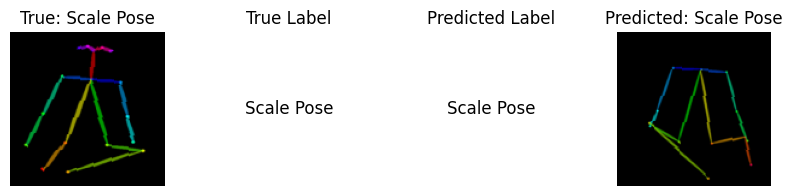

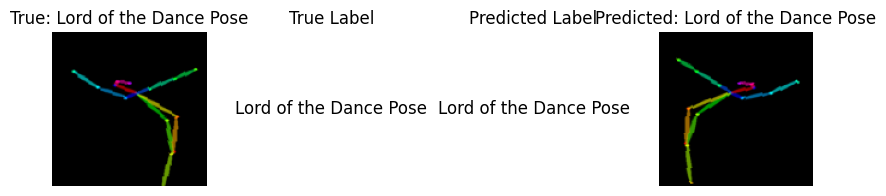

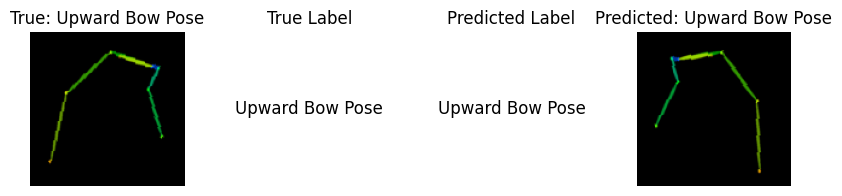

In [ ]:
visualize_test_results(model_residual_block, test_loader, dataset.classes)

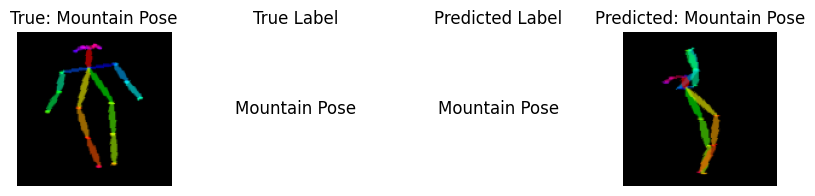

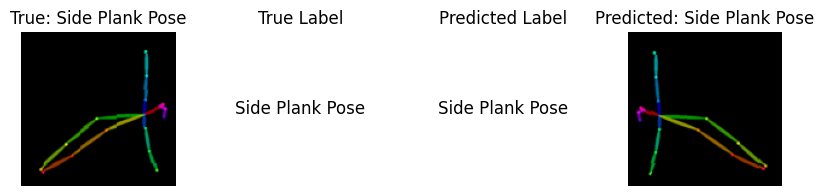

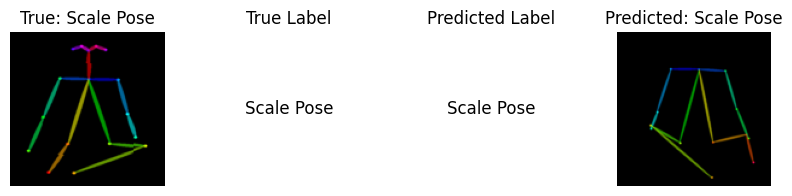

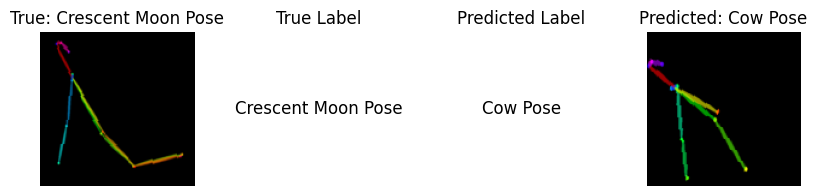

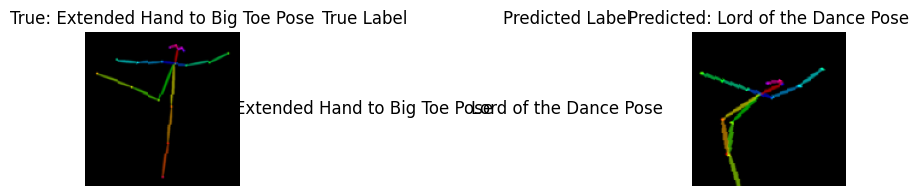

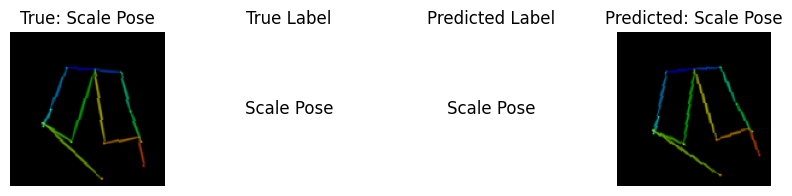

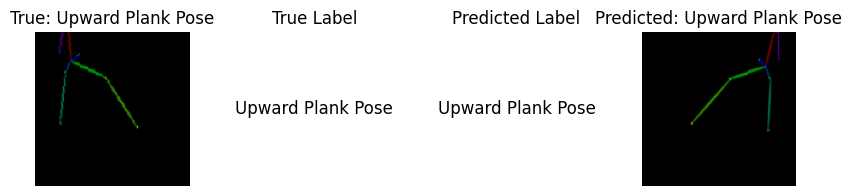

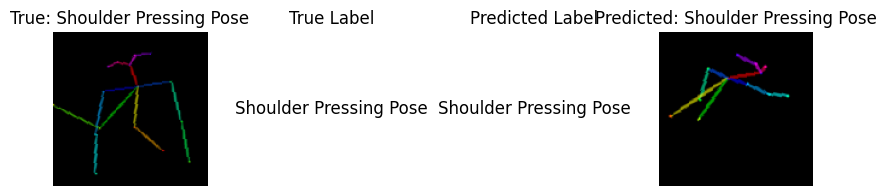

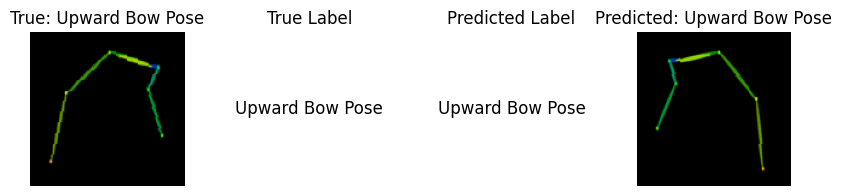

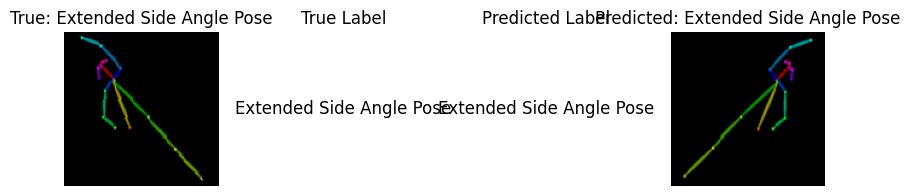

In [ ]:
visualize_test_results(model_residual_block, test_loader, dataset.classes)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd

def calculate_specific_class_metrics(y_true, y_pred, class_names, target_classes):
    # Calculate metrics for all classes
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)

    # Create a DataFrame with the results
    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Recall': recall,
        'Precision': precision,
        'F1': f1
    })

    # Filter the DataFrame to include only the target classes
    specific_classes_metrics = metrics_df[metrics_df['Class'].isin(target_classes)]

    # Display the metrics for the specific classes
    print(specific_classes_metrics)

    return specific_classes_metrics

# Define your specific classes
target_classes = ['Mountain Pose', 'Side Plank Pose', 'Scale Pose', 'Crescent Moon Pose']

specific_metrics = calculate_specific_class_metrics(y_true, y_pred, class_names, target_classes)


                 Class    Recall  Precision        F1
9   Crescent Moon Pose  0.642857   0.750000  0.692308
34       Mountain Pose  0.714286   0.555556  0.625000
41          Scale Pose  0.777778   0.666667  0.717949
44     Side Plank Pose  0.666667   0.600000  0.631579
